In [1]:
from comet_ml import Experiment, Optimizer

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import trange
import torch
import seaborn as sns
import os
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import sklearn
import sklearn.datasets
import time
import datetime

plt.style.use("seaborn")
torch.set_default_dtype(torch.float32)

/tmp/ipykernel_276559/2707165704.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
# import node

In [3]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score

In [4]:
# from tabular_hypernet import HypernetworkPCA, TrainingModes, Hypernetwork
from hypertab.modules import SimpleNetwork
from hypertab.interfaces import SimpleSklearnInterface
# from tabular_hypernet.training_utils import train_slow_step, train_model, train_carthesian
# from tabular_hypernet.interfaces import HypernetworkSklearnInterface, SimpleSklearnInterface
# from ipynb.fs.defs.MNIST_benchmark import test_model

In [5]:
import pyhopper

In [6]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

1

In [7]:
DEVICE = 'cuda:0'

In [19]:
DATA = "Cleveland"

## Load data

In [20]:
if DATA == "BreastCancer":
    dataset = sklearn.datasets.load_breast_cancer()
    X = dataset['data']
    y = dataset['target']
elif DATA == "Connectionist":
    dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data", header=None)
    X = dataset.values[:, :-1].astype(float)
    y = dataset.values[:, -1]
    y = LabelEncoder().fit_transform(y)
elif DATA == "Dermatology":
    dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/dermatology/dermatology.data", header=None, na_values="?").dropna()
    X = dataset.values[:, :-1].astype(float)
    y = dataset.values[:, -1].astype(int) - 1
elif DATA == "Flag":
    dataset = pd.read_csv("../data/flag/flag.data", header=None)
    X = dataset.values[:, 7:]
    y = dataset.values[:, 6].astype(int)

    X[:, -1] = LabelEncoder().fit_transform(X[:, -1])
    X[:, -2] = LabelEncoder().fit_transform(X[:, -2])
    X[:, 10] = LabelEncoder().fit_transform(X[:, 10])
    y = LabelEncoder().fit_transform(y).astype(int)
    
    X = X.astype(np.float32)
elif DATA == "Glass":
    dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data", header=None, na_values="?").dropna()
    X = dataset.values[:, :-1].astype(float)
    y = dataset.values[:, -1].astype(int)
    y = LabelEncoder().fit_transform(y).astype(int)
    
elif DATA == "Cleveland":
    dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", header=None, na_values="?").dropna()
    X = dataset.values[:, :-1].astype(float)
    y = dataset.values[:, -1].astype(int)
    y = LabelEncoder().fit_transform(y).astype(int)

elif DATA == "CNAE9":
    dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00233/CNAE-9.data", header=None, na_values="?").dropna()
    X = dataset.values[:, 1:].astype(float)
    y = dataset.values[:, 0].astype(int)
    y = LabelEncoder().fit_transform(y).astype(int)

max_size = int(len(X)*0.7)
print(X.shape, len(np.unique(y)), max_size)

(297, 13) 5 207


## Preprocess

In [10]:
np.random.seed(42)

def prepare_data(X, y, size=None):
    # todo: 20% valid, 20% test, 60% train
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y)
    # X_train, y_train = imblearn.over_sampling.RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train, X_test, y_train, y_test = [torch.from_numpy(x) for x in [X_train, X_test, y_train, y_test]]
    
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = prepare_data(X, y, size=0.2)
X_train = X_train.numpy()
y_train = y_train.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

## Benchmark

In [12]:
criterion = torch.nn.CrossEntropyLoss()

In [13]:
def _summarize_results(y_pred, y_score, y_test, labels):
    results = []
    for idx, label in enumerate(labels):
        y_pred_filt = y_pred[y_test==idx]
        y_test_filt = y_test[y_test==idx]
        acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
        results.append({
            "Class": label,
            "Metric": acc
        })
        
    acc = (y_pred==y_test.numpy()).sum()/len(y_test)*100    
    results.append({
        "Class": "Total",
        "Metric": acc
    })

    results.append({
        "Class": "balanced_accuracy",
        "Metric": balanced_accuracy_score(y_test, torch.from_numpy(y_pred)).item()*100
    })

    try:
        results.append({
            "Class": "F1 score",
            "Metric": f1_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "ROC score",
            "Metric": roc_auc_score(y_test, torch.from_numpy(y_score[:, 1])).item()*100
        })
        results.append({
            "Class": "Precision",
            "Metric": precision_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "Recall",
            "Metric": recall_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
    except (ValueError, TypeError):
        pass
    return results

def test_model(model_fn, data, train_size, label_encoder=None, iters=10, as_numpy=False):
    if label_encoder is not None:
        labels = label_encoder.classes_
    else:
        labels = sorted(np.unique(data[1]))
    
    results = []

    for i in range(iters):
        X_train, X_test, y_train, y_test = prepare_data(*data)
        
        model = model_fn()

        if as_numpy:
            model.fit(X_train.numpy(), y_train.numpy());
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        results.extend(_summarize_results(y_pred, y_score, y_test, labels))

    dframe = pd.DataFrame.from_dict(results)
    sns.violinplot(data=dframe[dframe["Class"]!="Loss"], y="Class", x="Metric", orient='h')
    return dframe

In [14]:
GS_METRIC = "balanced_accuracy"
def pyhopper_best_params(model_fn, param_grid, data_size=max_size, metric=GS_METRIC, time="1min"):
    def objective(params):
    #     print("Training...")
        model_results = test_model(
                        model_fn(
                            **params
                        ),
                        (X, y),
                        data_size,
                        None, 5)
        with open(f"{DATA}_{model_fn.__name__}_params.txt", "a") as f:
            f.write(str(params) + ", " + str(model_results[model_results["Class"]==metric]["Metric"].mean()) + "\n")
        return model_results[model_results["Class"]==metric]["Metric"].mean()

    search = pyhopper.Search(param_grid)

    best_params = search.run(objective, "maximize", time, seeding_ratio=0.5, ignore_nans=True)
    
    with open(f"{DATA}_{model_fn.__name__}_best_params.txt", "a") as f:
            f.write(str(best_params))
    
    print(f"{DATA}_{model_fn.__name__}_{best_params}")
    return best_params

### XGBoost

In [15]:
from xgboost import XGBClassifier

/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn

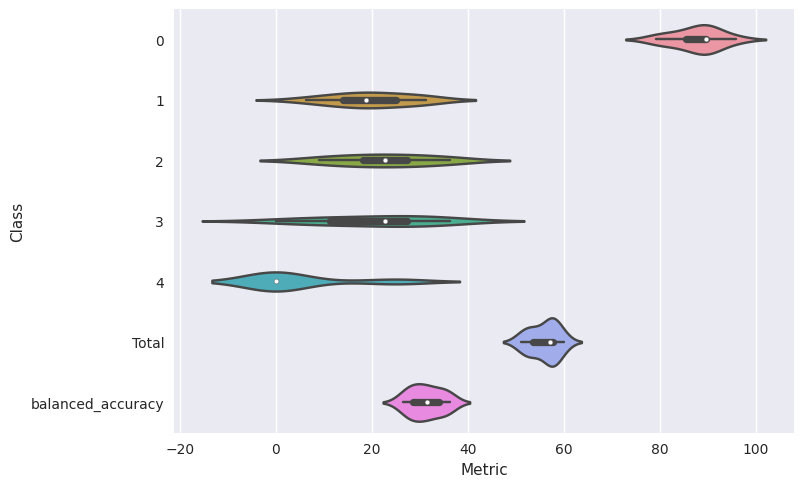

In [16]:
def get_xgboost():
    random_seed = np.random.randint(1024)
    return XGBClassifier(
        verbosity=0,
        random_state=random_seed,
        subsample=0.98,
        learning_rate=0.01,
        max_depth=6,
        use_label_encoder=False)

data_size = max_size

xgb_dframe = test_model(get_xgboost,
                        (X, y),
                        data_size,
                        label_encoder=None, iters=10)

In [46]:
res = xgb_dframe[xgb_dframe["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

NameError: name 'xgb_dframe' is not defined

### NODE

In [19]:
from qhoptim.pyt import QHAdam

In [20]:
def node_fn(layer_dims):
    def _inner():
        network = torch.nn.Sequential(
            node.DenseBlock(X_train.shape[1], layer_dims, num_layers=1, tree_dim=7, depth=3, flatten_output=False,
                           choice_function=node.entmax15, bin_function=node.entmoid15),
            node.Lambda(lambda x: x.mean(dim=1))
        )
        
        with torch.no_grad():
            res = network(torch.as_tensor(X_train[:1000], device='cpu').to(torch.float32))
        
        network = network.to(DEVICE)
        network.device=DEVICE
            
        optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
        optim = QHAdam(network.parameters(), **optimizer_params)
            
        network = SimpleSklearnInterface(network, device=DEVICE, epochs=150, batch_size=32)
        network.optimizer = optim
        return network
    return _inner

In [21]:
%%capture --no-stdout

for size in [max_size]:
    node_results = test_model(node_fn(128),
                        (X, y),
                        size,
                        label_encoder=None, iters=10)
    res = node_results[node_results["Class"]=="ROC score"].reset_index(drop=True)["Metric"]
    print(f"{size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

149: nan ~ nan, (max: nan)


In [23]:
res = node_results[node_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

149: 73.54 ~ 3.31, (max: 78.46)


In [137]:
res = node_results[node_results["Class"]=="ROC score"].reset_index(drop=True)["Metric"]

In [24]:
node_results[node_results["Class"]=="ROC score"].reset_index(drop=True)

,Class,Metric


### Neural network

In [43]:
def network_fn():
    def _inner():
        network = torch.nn.Sequential(
                        torch.nn.Dropout(1-7/10),
                        torch.nn.Linear(10, 50),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(0.5),
                        torch.nn.Linear(50, 6)
                    ).to(DEVICE).train()

        network = SimpleSklearnInterface(network, epochs=150, batch_size=32)
        return network
    return _inner

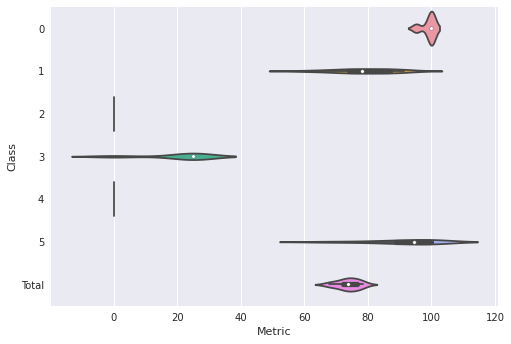

In [44]:
data_size = max_size

nn_results = test_model(network_fn(),
                (X, y),
                data_size,
                None, 10)

In [26]:
res = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

398: 97.84 ~ 0.87 (max: 99.42)


### Bagged Neural Network

In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier

def bagged_fn(first_hidden_layer, second_hidden_layer, batch_size, max_iter):
    def _inner():
        model = BaggingClassifier(estimator=MLPClassifier(hidden_layer_sizes=(first_hidden_layer, second_hidden_layer), max_iter=max_iter, batch_size=batch_size, verbose=False))
        return model
    return _inner

  0%|          | [00:00<?]

Search is scheduled for 10:00 (m:s)


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iteratio

==================== Summary ===================
Mode              : Best f : Steps : Time       
----------------  : ----   : ----  : ----       
Initial solution  : 94.07  : 1     : 01:13 (m:s)
Random seeding    : 94.2   : 4     : 04:04 (m:s)
Local sampling    : 94.38  : 6     : 04:13 (m:s)
Duplicates        : -      : 2     : -          
----------------  : ----   : ----  : ----       
Total             : 94.38  : 13    : 09:30 (m:s)
CNAE9_bagged_fn_{'first_hidden_layer': 200, 'second_hidden_layer': 200, 'batch_size': 320, 'max_iter': 50}


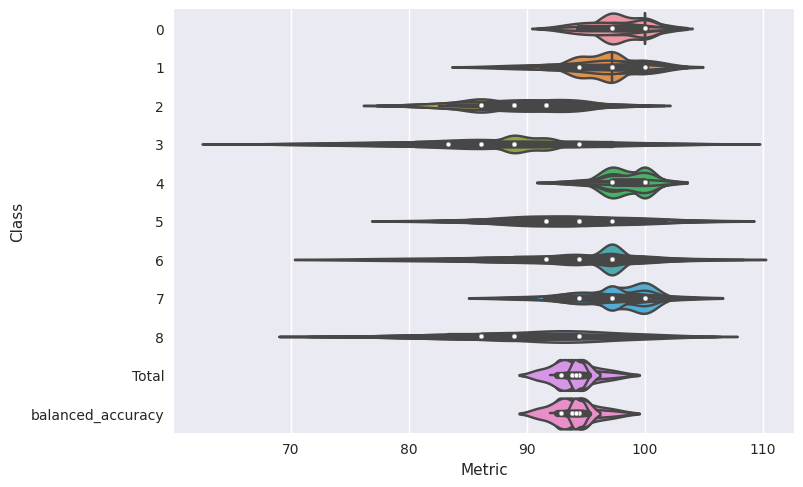

In [30]:
pyhopper_grid = {
    "first_hidden_layer": pyhopper.int(50, 500, 50, 50),
    "second_hidden_layer": pyhopper.int(50, 500, 50, 50),
    "batch_size": pyhopper.int(32, 512, 32, 32),
    "max_iter": pyhopper.int(50, 500, 50, 50)
}

best = pyhopper_best_params(bagged_fn, pyhopper_grid, max_size, time="10min")

In [31]:
best

{'first_hidden_layer': 200,
 'second_hidden_layer': 200,
 'batch_size': 320,
 'max_iter': 50}

/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iteratio

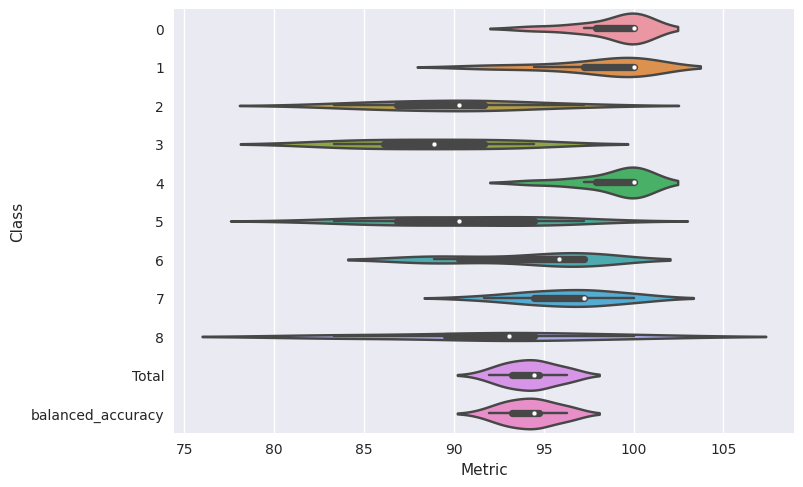

In [32]:
nn_results = test_model(bagged_fn(**best),
                (X, y),
                max_size,
                None, 10)

In [33]:
res = nn_results[nn_results["Class"]=="balanced_accuracy"].reset_index(drop=True)["Metric"]
print(f"{max_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

756: 94.23 ~ 1.42 (max: 96.30)


### DeepTLF

In [23]:
from DeepTLF.src import DeepTFL

In [24]:
def dtlf_fn(**kwargs):
    def _inner():
        # model = DeepTFL(n_est=23, max_depth=3, drop=0.23, n_layers=4, task='class')
        model = DeepTFL(task='class', batchsize=32, **kwargs)
        return model
    return _inner

# data_size = max_size

# nn_results = test_model(dtlf_fn,
#                 (X, y),
#                 data_size,
#                 None, 10)

In [25]:
pyhopper_grid = {
    "n_est": pyhopper.int(10, 100, 10, 10),
    "max_depth": pyhopper.int(2, 10, 2, 1),
    "drop": pyhopper.float(0.1, 0.9),
    "n_layers": pyhopper.int(2, 10, 4, 1),
}

best = pyhopper_best_params(dtlf_fn, pyhopper_grid, max_size, time="20min")

  0%|          | [00:00<?]

Search is scheduled for 20:00 (m:s)


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief




















Epochs:   1%|          | 93/10000 [00:02<04:22, 37.79it/s]

Early stopping
LOSS: 20.839816331863403
Num epochs: 93



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief



















Epochs:   1%|          | 87/10000 [00:01<03:22, 48.92it/s]

Early stopping
LOSS: 8.962603410085041
Num epochs: 87



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief






















Epochs:   1%|          | 102/10000 [00:02<03:26, 47.90it/s]

Early stopping
LOSS: 10.143540302912395
Num epochs: 102



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief

















Epochs:   1%|          | 75/10000 [00:01<03:28, 47.50it/s]

Early stopping
LOSS: 7.7814822395642596
Num epochs: 75



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief























Epochs:   1%|          | 118/10000 [00:02<03:16, 50.28it/s]

Early stopping
LOSS: 12.187469998995464
Num epochs: 118



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief



























Epochs:   1%|          | 72/10000 [00:02<06:30, 25.40it/s]

Early stopping
LOSS: 15.040990710258484
Num epochs: 72



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief




























Epochs:   1%|          | 77/10000 [00:02<06:20, 26.05it/s]

Early stopping
LOSS: 14.151175816853842
Num epochs: 77



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief




























Epochs:   1%|          | 75/10000 [00:02<06:36, 25.01it/s]

Early stopping
LOSS: 13.059072693188986
Num epochs: 75



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief

































Epochs:   1%|          | 90/10000 [00:03<06:22, 25.90it/s]

Early stopping
LOSS: 12.012452880541485
Num epochs: 90



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief



























Epochs:   1%|          | 73/10000 [00:02<06:21, 25.99it/s]

Early stopping
LOSS: 50.02676248550415
Num epochs: 73



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


















Epochs:   1%|          | 59/10000 [00:01<05:27, 30.36it/s]

Early stopping
LOSS: 34.46047306060791
Num epochs: 59



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief































Epochs:   1%|          | 104/10000 [00:03<05:33, 29.65it/s]

Early stopping
LOSS: 13.724998633066813
Num epochs: 104



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


































Epochs:   1%|▏         | 125/10000 [00:04<05:21, 30.74it/s]

Early stopping
LOSS: 9.794968366622925
Num epochs: 125



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief





















Epochs:   1%|          | 70/10000 [00:02<05:31, 29.94it/s]

Early stopping
LOSS: 10.5295330286026
Num epochs: 70



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief























Epochs:   1%|          | 78/10000 [00:02<05:14, 31.56it/s]

Early stopping
LOSS: 22.53511746724447
Num epochs: 78



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief



















Epochs:   1%|          | 79/10000 [00:01<04:01, 41.07it/s]

Early stopping
LOSS: 25.949150323867798
Num epochs: 79



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
















Epochs:   1%|          | 63/10000 [00:01<04:16, 38.67it/s]

Early stopping
LOSS: 28.9864718914032
Num epochs: 63



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
























Epochs:   1%|          | 102/10000 [00:02<04:23, 37.51it/s]

Early stopping
LOSS: 7.978362341721852
Num epochs: 102



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief

















Epochs:   1%|          | 72/10000 [00:01<04:07, 40.10it/s]

Early stopping
LOSS: 25.657955805460613
Num epochs: 72



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
















Epochs:   1%|          | 57/10000 [00:01<04:39, 35.56it/s]

Early stopping
LOSS: 25.38743019104004
Num epochs: 57



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief



















Epochs:   1%|          | 61/10000 [00:01<05:19, 31.14it/s]

Early stopping
LOSS: 40.32011826833089
Num epochs: 61



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief




















Epochs:   1%|          | 71/10000 [00:02<04:52, 33.96it/s]

Early stopping
LOSS: 13.551624615987143
Num epochs: 71



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief

























Epochs:   1%|          | 88/10000 [00:02<05:08, 32.13it/s]

Early stopping
LOSS: 14.762325088183085
Num epochs: 88



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


















Epochs:   1%|          | 63/10000 [00:01<04:51, 34.09it/s]

Early stopping
LOSS: 17.9247518380483
Num epochs: 63



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief































Epochs:   1%|          | 106/10000 [00:03<05:12, 31.67it/s]

Early stopping
LOSS: 22.90249069531759
Num epochs: 106



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief











































































Epochs:   2%|▏         | 187/10000 [00:10<09:17, 17.62it/s]

Early stopping
LOSS: 9.27915672461192
Num epochs: 187



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief














































Epochs:   1%|▏         | 127/10000 [00:06<07:51, 20.94it/s]

Early stopping
LOSS: 10.328689217567444
Num epochs: 127



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


























































Epochs:   1%|▏         | 141/10000 [00:07<08:33, 19.18it/s]

Early stopping
LOSS: 21.223042408625282
Num epochs: 141



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief






































































Epochs:   2%|▏         | 173/10000 [00:09<09:06, 17.98it/s]

Early stopping
LOSS: 9.465810656547546
Num epochs: 173



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief

















































































Epochs:   2%|▏         | 234/10000 [00:09<06:24, 25.38it/s]

Early stopping
LOSS: 8.170591294765472
Num epochs: 234



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief




























Epochs:   1%|          | 110/10000 [00:02<04:25, 37.29it/s]

Early stopping
LOSS: 11.67997419834137
Num epochs: 110



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


































Epochs:   1%|▏         | 131/10000 [00:04<05:10, 31.82it/s]

Early stopping
LOSS: 9.217376510302227
Num epochs: 131



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
























Epochs:   1%|          | 85/10000 [00:02<05:01, 32.90it/s]

Early stopping
LOSS: 15.336699287096659
Num epochs: 85



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


























Epochs:   1%|          | 97/10000 [00:02<04:33, 36.16it/s]

Early stopping
LOSS: 17.294897635777794
Num epochs: 97



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
























Epochs:   1%|          | 84/10000 [00:02<04:39, 35.44it/s]

Early stopping
LOSS: 10.658348600069683
Num epochs: 84



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
















Epochs:   1%|          | 69/10000 [00:01<03:31, 46.91it/s]

Early stopping
LOSS: 12.295719981193542
Num epochs: 69



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief












Epochs:   1%|          | 56/10000 [00:01<03:22, 48.99it/s]


Early stopping
LOSS: 35.56385437647502
Num epochs: 56


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief














Epochs:   1%|          | 62/10000 [00:01<03:19, 49.90it/s]

Early stopping
LOSS: 23.56396516164144
Num epochs: 62



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
















Epochs:   1%|          | 67/10000 [00:01<03:37, 45.58it/s]

Early stopping
LOSS: 16.126530369122825
Num epochs: 67



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief

















Epochs:   1%|          | 69/10000 [00:01<04:02, 40.89it/s]

Early stopping
LOSS: 14.171507954597473
Num epochs: 69



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief










Epochs:   1%|          | 53/10000 [00:00<02:35, 64.07it/s]

Early stopping
LOSS: 23.093454043070473
Num epochs: 53



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief












Epochs:   1%|          | 66/10000 [00:00<02:26, 67.69it/s]

Early stopping
LOSS: 18.573784828186035
Num epochs: 66



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief














Epochs:   1%|          | 86/10000 [00:01<02:29, 66.51it/s]

Early stopping
LOSS: 9.93240972359975
Num epochs: 86



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief












Epochs:   1%|          | 65/10000 [00:00<02:28, 66.89it/s]

Early stopping
LOSS: 12.690791487693787
Num epochs: 65



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief













Epochs:   1%|          | 79/10000 [00:01<02:27, 67.30it/s]

Early stopping
LOSS: 9.710948665936787
Num epochs: 79



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief











Epochs:   1%|          | 61/10000 [00:00<02:31, 65.70it/s]

Early stopping
LOSS: 17.707143227259316
Num epochs: 61



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief











Epochs:   1%|          | 54/10000 [00:00<02:52, 57.67it/s]

Early stopping
LOSS: 29.948105414708454
Num epochs: 54



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief












Epochs:   1%|          | 62/10000 [00:01<02:40, 61.82it/s]

Early stopping
LOSS: 12.997528910636902
Num epochs: 62



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief












Epochs:   1%|          | 64/10000 [00:01<02:37, 62.90it/s]

Early stopping
LOSS: 15.604657928148905
Num epochs: 64



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief











Epochs:   1%|          | 61/10000 [00:00<02:31, 65.51it/s]

Early stopping
LOSS: 13.865494728088379
Num epochs: 61



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief























Epochs:   1%|          | 80/10000 [00:02<05:05, 32.51it/s]

Early stopping
LOSS: 8.718629678090412
Num epochs: 80



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief






























Epochs:   1%|          | 110/10000 [00:03<05:01, 32.77it/s]

Early stopping
LOSS: 18.137011925379433
Num epochs: 110



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief





























Epochs:   1%|          | 102/10000 [00:03<05:04, 32.46it/s]

Early stopping
LOSS: 11.859695116678875
Num epochs: 102



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


























Epochs:   1%|          | 92/10000 [00:02<04:55, 33.59it/s]

Early stopping
LOSS: 13.008750478426615
Num epochs: 92



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief








































Epochs:   1%|▏         | 147/10000 [00:04<05:04, 32.39it/s]

Early stopping
LOSS: 45.75057029724121
Num epochs: 147



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
















































Epochs:   1%|▏         | 140/10000 [00:05<06:12, 26.45it/s]

Early stopping
LOSS: 6.27561757961909
Num epochs: 140



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief





































Epochs:   1%|          | 106/10000 [00:04<06:28, 25.49it/s]


Early stopping
LOSS: 15.813469886779785
Num epochs: 106


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief









































Epochs:   1%|          | 124/10000 [00:04<06:13, 26.44it/s]

Early stopping
LOSS: 6.248392661412558
Num epochs: 124



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
























Epochs:   1%|          | 79/10000 [00:02<05:43, 28.85it/s]

Early stopping
LOSS: 21.16034229596456
Num epochs: 79



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief







































Epochs:   1%|          | 121/10000 [00:04<05:54, 27.85it/s]

Early stopping
LOSS: 17.073325316111244
Num epochs: 121



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief











Epochs:   1%|          | 51/10000 [00:00<03:06, 53.26it/s]

Early stopping
LOSS: 24.384786685307823
Num epochs: 51



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief











Epochs:   1%|          | 52/10000 [00:01<03:14, 51.21it/s]

Early stopping
LOSS: 29.716835419336956
Num epochs: 52



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief













Epochs:   1%|          | 63/10000 [00:01<03:03, 54.03it/s]

Early stopping
LOSS: 16.592660546302795
Num epochs: 63



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief











Epochs:   1%|          | 60/10000 [00:01<02:59, 55.46it/s]

Early stopping
LOSS: 20.602009693781532
Num epochs: 60



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief











Epochs:   1%|          | 57/10000 [00:01<03:03, 54.19it/s]

Early stopping
LOSS: 31.54921531677246
Num epochs: 57



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
















Epochs:   1%|          | 61/10000 [00:01<04:20, 38.19it/s]

Early stopping
LOSS: 27.29210654894511
Num epochs: 61



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief





















Epochs:   1%|          | 75/10000 [00:02<04:42, 35.13it/s]

Early stopping
LOSS: 15.925852457682291
Num epochs: 75



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
























Epochs:   1%|          | 92/10000 [00:02<04:20, 38.04it/s]


Early stopping
LOSS: 37.39936749140422
Num epochs: 92


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief













































Epochs:   1%|          | 121/10000 [00:06<08:13, 20.04it/s]

Early stopping
LOSS: 29.225389162699383
Num epochs: 121



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief






























Epochs:   1%|          | 93/10000 [00:03<06:12, 26.61it/s]

Early stopping
LOSS: 14.71524735291799
Num epochs: 93



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief




















Epochs:   1%|          | 71/10000 [00:02<05:11, 31.91it/s]

Early stopping
LOSS: 15.310636162757874
Num epochs: 71



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
























Epochs:   1%|          | 88/10000 [00:02<05:06, 32.36it/s]

Early stopping
LOSS: 7.632295290629069
Num epochs: 88



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief





















Epochs:   1%|          | 87/10000 [00:02<04:22, 37.72it/s]

Early stopping
LOSS: 15.067659815152487
Num epochs: 87



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief























































Epochs:   2%|▏         | 241/10000 [00:06<04:30, 36.01it/s]

Early stopping
LOSS: 6.587936480840047
Num epochs: 241



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief































Epochs:   1%|          | 117/10000 [00:03<05:20, 30.80it/s]

Early stopping
LOSS: 9.078759948412578
Num epochs: 117



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief




























Epochs:   1%|          | 103/10000 [00:03<05:00, 32.99it/s]

Early stopping
LOSS: 8.589785297711689
Num epochs: 103



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


















Epochs:   1%|          | 69/10000 [00:01<04:27, 37.11it/s]

Early stopping
LOSS: 21.104498704274498
Num epochs: 69



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief























Epochs:   1%|          | 81/10000 [00:02<05:27, 30.27it/s]

Early stopping
LOSS: 9.445903698603313
Num epochs: 81



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief



































Epochs:   1%|▏         | 127/10000 [00:04<05:36, 29.33it/s]

Early stopping
LOSS: 10.612138112386067
Num epochs: 127



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
























































Epochs:   2%|▏         | 244/10000 [00:06<04:20, 37.41it/s]

Early stopping
LOSS: 6.640905141830444
Num epochs: 244



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief






















Epochs:   1%|          | 62/10000 [00:02<05:55, 27.94it/s]

Early stopping
LOSS: 19.67392166455587
Num epochs: 62



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief






















Epochs:   1%|          | 59/10000 [00:02<06:39, 24.87it/s]

Early stopping
LOSS: 18.235421180725098
Num epochs: 59



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief





































Epochs:   1%|          | 97/10000 [00:04<08:03, 20.47it/s]

Early stopping
LOSS: 18.44727794329325
Num epochs: 97



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief























Epochs:   1%|          | 61/10000 [00:02<07:41, 21.55it/s]

Early stopping
LOSS: 19.902596871058144
Num epochs: 61



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief




















Epochs:   1%|          | 67/10000 [00:02<05:29, 30.14it/s]

Early stopping
LOSS: 12.859218319257101
Num epochs: 67



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief




















Epochs:   1%|          | 78/10000 [00:02<04:44, 34.82it/s]

Early stopping
LOSS: 15.331507722536722
Num epochs: 78



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
















Epochs:   1%|          | 57/10000 [00:01<05:03, 32.74it/s]

Early stopping
LOSS: 42.439401149749756
Num epochs: 57



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
















Epochs:   1%|          | 66/10000 [00:01<04:26, 37.24it/s]


Early stopping
LOSS: 21.263140439987183
Num epochs: 66


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief






















Epochs:   1%|          | 86/10000 [00:02<05:13, 31.63it/s]


Early stopping
LOSS: 12.589847048123678
Num epochs: 86


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief

















Epochs:   1%|          | 69/10000 [00:01<04:15, 38.92it/s]

Early stopping
LOSS: 23.013697067896523
Num epochs: 69



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief




















Epochs:   1%|          | 66/10000 [00:02<06:58, 23.76it/s]

Early stopping
LOSS: 13.866528868675232
Num epochs: 66



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief






















Epochs:   1%|          | 85/10000 [00:02<04:48, 34.40it/s]

Early stopping
LOSS: 12.442159652709961
Num epochs: 85



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief

























Epochs:   1%|          | 110/10000 [00:02<04:14, 38.92it/s]

Early stopping
LOSS: 9.628653526306152
Num epochs: 110



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief
































Epochs:   1%|          | 108/10000 [00:03<06:03, 27.20it/s]

Early stopping
LOSS: 11.40415569146474
Num epochs: 108



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


Epochs:   2%|▏         | 213/10000 [00:03<02:57, 55.24it/s]

Early stopping
LOSS: 2.255531204374213
Num epochs: 213



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


Epochs:   4%|▍         | 430/10000 [00:08<03:02, 52.45it/s]

Early stopping
LOSS: 0.0023575551734354933
Num epochs: 430



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


Epochs:   3%|▎         | 341/10000 [00:05<02:48, 57.19it/s]

Early stopping
LOSS: 0.47269043953795176
Num epochs: 341



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


Epochs:   4%|▎         | 355/10000 [00:07<03:21, 47.87it/s]

Early stopping
LOSS: 0.7266090888726084
Num epochs: 355



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


Epochs:   4%|▍         | 409/10000 [00:07<02:52, 55.65it/s]

Early stopping
LOSS: 0.5673792409269433
Num epochs: 409



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


Epochs:   3%|▎         | 314/10000 [00:05<03:00, 53.79it/s]

Early stopping
LOSS: 0.31412371287220403
Num epochs: 314



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


Epochs:   1%|▏         | 131/10000 [00:02<03:05, 53.22it/s]

Early stopping
LOSS: 2.713167667388916
Num epochs: 131



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


Epochs:   5%|▍         | 478/10000 [00:08<02:58, 53.27it/s]

Early stopping
LOSS: 0.09019834626662103
Num epochs: 478



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


Epochs:   2%|▏         | 210/10000 [00:04<03:07, 52.26it/s]

Early stopping
LOSS: 0.9527222106331273
Num epochs: 210



/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Weight decoupling enabled in AdaBelief


Epochs:   3%|▎         | 320/10000 [00:05<02:58, 54.26it/s]

Early stopping
LOSS: 1.0654996100224947
Num epochs: 320


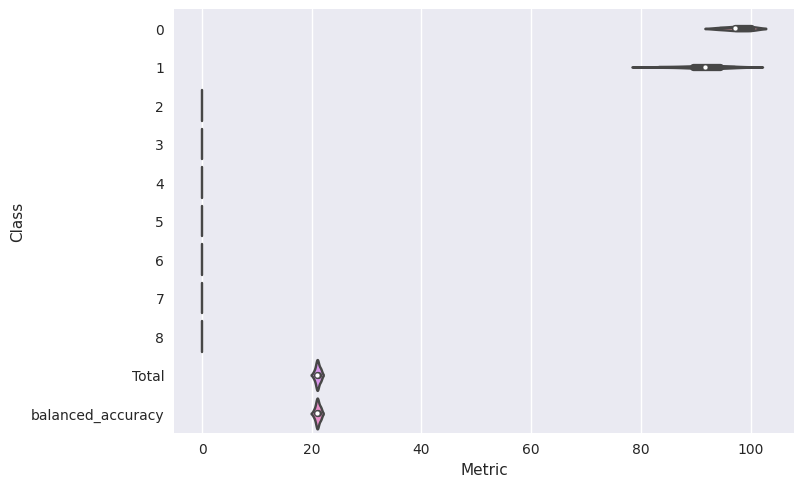

In [ ]:
nn_results = test_model(dtlf_fn(**best),
                (X, y),
                max_size,
                None, 10)

In [ ]:
res = nn_results[nn_results["Class"]=="balanced_accuracy"].reset_index(drop=True)["Metric"]
print(f"{max_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

756: 21.05 ~ 0.38 (max: 21.60)


### HypernetworkPCA

In [30]:
def network_pca_fn(target_size, mask_size, masks_no=100):
    def _inner():
        hypernet = HypernetworkPCA(
                        target_architecture=[(mask_size, target_size), (target_size, 7)], 
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(5, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                        input_size=10
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=64)
        return network
    return _inner

In [25]:
def figure_to_html():
    tmpfile = BytesIO()
    plt.gcf().savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    return html

In [22]:
epochs = 100
masks_no = 20
mask_size = 3
target_size = 20
data_size = max_size

nn_results = test_model(network_pca_fn(target_size, mask_size, masks_no),
                (X, y),
                data_size,
                None, 10)

# exp.log_table("metrics.csv", nn_results.groupby("Class").mean())
# exp.log_metric("f1_score", nn_results.groupby("Class").mean().loc["F1 score"])

NameError: name 'network_pca_fn' is not defined

In [31]:
res = nn_results[nn_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

149: 90.31 ~ 7.07 (max: 96.92)


In [ ]:
mask_size = 5
total = 15
current = 0

res = {}
for epochs in [100, 150, 200, 300, 500]:
    for masks_no in [50, 30, 70]:
        current += 1
        description = f"{epochs=}, {mask_size=}, {masks_no=}"
        exp = Experiment(os.environ.get("COMET_KEY"), "blastchar-hypernet")

        nn_results = test_model(network_fn(epochs, mask_size, masks_no),
                        (X, y),
                        y_label_enc, 4, data_size=100)

        exp.log_parameters({"epochs": epochs, "mask_size": mask_size, "masks_no": masks_no})
        exp.add_tag("hypernet-full-optim")
        exp.log_table("metrics.csv", nn_results.groupby("Class").mean())
        exp.log_metric("f1_score", nn_results.groupby("Class").mean().loc["F1 score"])

        res[description] = nn_results
        logger.info(description)
        logger.info(f"{current}/{total}")
        print_statistics(res[description])

In [70]:
for key in res.keys():
    print(key)
    print_statistics(res[key])

epochs=100, mask_size=5, masks_no=50
F1: 60.890 ~ 1.154
C-statistics: 83.136 ~ 0.376
Precision: 53.227 ~ 5.449
Recall: 72.538 ~ 8.134
epochs=100, mask_size=5, masks_no=30
F1: 60.464 ~ 1.268
C-statistics: 82.603 ~ 0.516
Precision: 49.242 ~ 4.728
Recall: 79.565 ~ 7.094
epochs=100, mask_size=5, masks_no=70
F1: 49.704 ~ 10.204
C-statistics: 82.516 ~ 1.119
Precision: 65.107 ~ 6.064
Recall: 43.269 ~ 17.677


In [66]:
exp.run_id

'RKwbRoPWKvsMjkjK3JobL0J5e'

### Hypernetwork

In [16]:
from hypertab import Hypernetwork, TrainingModes
from hypertab.interfaces import HypernetworkSklearnInterface

def network_fn(epochs=150, masks_no=100, mask_size=100, target_size=100):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, 6)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(30, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=64)
        return network
    return _inner

#### Find hyperparams

In [17]:
epochs = 100
mask_size = 10
masks_no = 80
data_size = max_size
results = defaultdict(dict)


def objective(params):
    epochs = params['epochs']
    masks_no = params['masks_no']
    mask_size = params['mask_size']
    target_size = params['target_size']
    print("Training...")
    nn_results = test_model(network_fn(epochs, masks_no, mask_size, target_size),
                    (X_train, y_train),
                    data_size,
                    None, 4)
    with open("sonar_params.txt", "a") as f:
        f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
    return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]

search = pyhopper.Search(
    {
        "epochs": pyhopper.int(50, 150, multiple_of=10),
        "masks_no": pyhopper.int(20, 100, multiple_of=10),
        "mask_size": pyhopper.int(5, 25),
        "target_size": pyhopper.choice([10, 20, 50, 100]),
    }
)

# An run the optimization for 60 minutes
best_params = search.run(objective, "maximize", "30m", n_jobs="2x per-gpu", seeding_ratio=0.5)

  0%|          | [00:00<?]

Search is scheduled for 30:00 (m:s)
Training...Training...

Training...Training...Training...
Training...
Training...Training...





100%|██████████| 90/90 [00:44<00:00,  2.03it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 140/140 [00:49<00:00,  2.84it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 120/120 [00:51<00:00,  2.34it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 140/140 [01:08<00:00,  2.04it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 100/100 [01:31<00:00,  1.09it/s]

 68%|██████▊   | 68/100 [01:29<00:41,  1.31s/it]/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]

Training...


100%|██████████| 80/80 [01:42<00:00,  1.28s/it]]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 110/110 [01:56<00:00,  1.06s/it]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 140/140 [01:17<00:00,  1.82it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 60/60 [00:41<00:00,  1.45it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 90/90 [01:21<00:00,  1.10it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 140/140 [02:05<00:00,  1.12it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...

100%|██████████| 60/60 [00:40<00:00,  1.49it/s]

 45%|████▌     | 63/140 [01:22<01:46,  1.39s/it]/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...

100%|██████████| 90/90 [01:10<00:00,  1.28it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 60/60 [01:21<00:00,  1.36s/it]

/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]

Training...


100%|██████████| 100/100 [02:30<00:00,  1.50s/it]

  2%|▎         | 2/80 [00:01<01:11,  1.09it/s]/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...

100%|██████████| 150/150 [01:04<00:00,  2.33it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 80/80 [01:23<00:00,  1.04s/it]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]



Training...


100%|██████████| 100/100 [02:07<00:00,  1.28s/it]A
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 140/140 [02:26<00:00,  1.05s/it]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 70/70 [00:47<00:00,  1.47it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 80/80 [00:52<00:00,  1.53it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 120/120 [02:38<00:00,  1.32s/it]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]


Training...


100%|██████████| 140/140 [02:55<00:00,  1.25s/it]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")

  9%|▊         | 12/140 [00:10<01:51,  1.14it/s]/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]

Training...


100%|██████████| 130/130 [02:56<00:00,  1.36s/it]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  f.write(str(params) + ", " + str(nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]) + "\n")
/tmp/ipykernel_276559/2996940292.py:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return nn_results[nn_results["Class"]=="Total"].reset_index(drop=True).mean().values[0]
100%|██████████| 60/60 [00:47<00:00,  1.27it/s]
/tmp/ipykernel_276559/2996940292.py:19: FutureWarning: 

====================== Summary ======================
Mode              : Best f : Steps : Time            
----------------  : ----   : ----  : ----            
Initial solution  : 96.55  : 1     : 06:09 (m:s)     
Random seeding    : 100    : 23    : 02:28:13 (h:m:s)
Local sampling    : 98.28  : 10    : 30:08 (m:s)     
Duplicates        : -      : 1     : -               
----------------  : ----   : ----  : ----            
Total             : 100    : 35    : 23:20 (m:s)     


In [18]:
best_params

{'epochs': 100, 'masks_no': 80, 'mask_size': 7, 'target_size': 10}

#### Train using the best hyperparams

torch.Size([1, 128])


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:38<00:00,  2.18s/it]


torch.Size([1, 128])


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


torch.Size([1, 128])


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


torch.Size([1, 128])


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


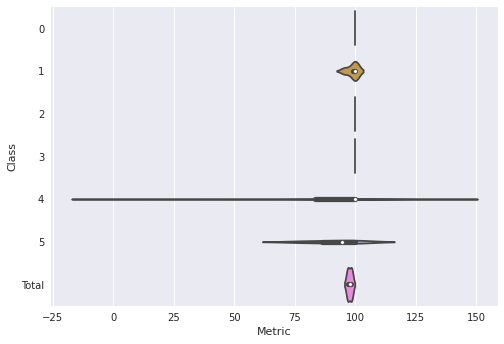

In [21]:
epochs = 100
masks_no = 80
mask_size = 7
target_size = 10
data_size = max_size

hyper_results = test_model(network_fn(epochs, masks_no, mask_size, target_size),
                    (X, y),
                    data_size,
                    None, 4)

In [22]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

149: 97.69 ~ 0.89, (max: 98.46)


In [48]:
hyper_results[hyper_results["Class"]=="ROC score"].reset_index(drop=True)

,Class,Metric


### Random forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

149: nan ~ nan, (max: nan)


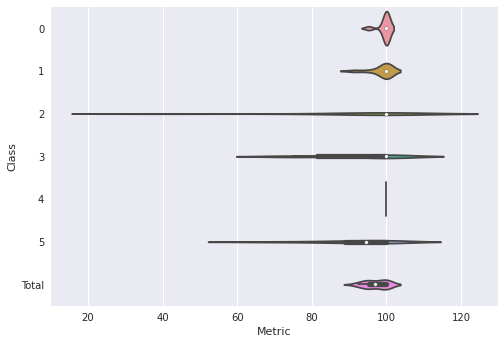

In [24]:
def get_rf():
    def _inner():
        random_seed = np.random.randint(1024)
        return RandomForestClassifier(
            random_state=random_seed)
    return _inner


for size in [max_size][::-1]:
    rf_dframe = test_model(get_rf(), 
                            (X, y),
                            size,
                            None, iters=10)
    res = rf_dframe[rf_dframe["Class"]=="ROC score"].reset_index(drop=True)["Metric"]
    print(f"{size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

In [25]:
res = rf_dframe[rf_dframe["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

149: 97.08 ~ 2.94, (max: 100.00)
